<a href="https://colab.research.google.com/github/sohumgautam17/Cell_Seg_Count-CMU/blob/main/CMU_CSegNET_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cell Segmentation Imports

In [3]:
import torch
if torch.backends.mps.is_available():
    print("MPS is available.")
else:
    print("MPS is not available.")

MPS is available.


In [2]:
import torch
import sklearn
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import requests
from pathlib import Path
import xml.etree.ElementTree as ET
from PIL import Image
from torch import nn
import torch.nn.functional as F
import sys

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from tqdm.auto import tqdm
from torchvision.transforms.functional import hflip, vflip
import torchinfo
from torchinfo import summary
import glob

/Users/sohumgautam/opt/miniconda3/envs/cmu_sohum_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#Download and Parse CryoNuSeg + Augmentations


In [52]:
from process_data import pdf_to_binary, he_to_binary_mask
image_path = './CryoNuSeg_Images'
annotations_path = './Cryo_Annotater_1'

image_array = []
annotation_array = []

# Get lists of image and annotation file paths
image_files = sorted(os.listdir(image_path))
annotation_files = sorted(os.listdir(annotations_path))

# Iterate over both lists simultaneously using zip()
for image_file in image_files:
    image_path_full = os.path.join(image_path, image_file)
    image_numpy = pdf_to_binary(image_path_full)
    image_array.append(image_numpy)

for annotation_file in annotation_files:
    annotation_path_full = os.path.join(annotations_path, annotation_file)
    annotation_numpy = pdf_to_binary(annotation_path_full)
    annotation_array.append(annotation_numpy)

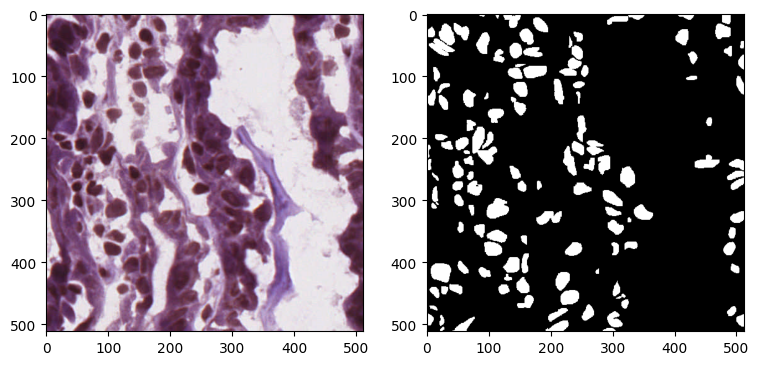

In [36]:
image = 29
ex_image = image_array[image - 1]
ex_annotation = annotation_array[image - 1]
fig, ax = plt.subplots(1, 2, figsize=(9,9))
ax[0].imshow(np.squeeze(ex_image))
ax[1].imshow(np.squeeze(ex_annotation))

In [76]:
# From Augmentions.py imported Resize to 1000, 1000 becaseu CryoNuSeg images are 512, 512
#This is to match the pixel size of MoNuSeg
from albumentations import Resize
resize = Resize(1000, 1000)
image_array_augmented = []
def apply_resize(im):
    for i in image_array:
        image_array_augmented.append(resize(image=i))
    return image_array_augmented



#Download and Parse MoNuSeg + Augmentaitons

In [37]:
files_path = "./MoNuSeg_Images"
filename = []

for each_file in os.listdir(files_path):
  each_file = each_file[:-4]
  filename.append(each_file)

print(filename[:5])

['TCGA-G9-6348-01Z-00-DX1', 'TCGA-E2-A1B5-01Z-00-DX1', 'TCGA-CH-5767-01Z-00-DX1', 'TCGA-AR-A1AS-01Z-00-DX1', 'TCGA-G9-6336-01Z-00-DX1']


In [43]:
num_of_images_in_pipeline = 30
filename = filename[:num_of_images_in_pipeline]
orig_binmask_colormask = []
for i in filename:
  orig_binmask_colormask.append(he_to_binary_mask(i))
len(orig_binmask_colormask)

30

In [44]:
for data in orig_binmask_colormask:
    first_key, first_value = next(iter(data.items()))
    image_array = np.array(first_value)
    img_flip_ud = cv2.flip(image_array, 0)
    img_rotated = np.rot90(img_flip_ud, k=3)
    data[first_key] = img_rotated

In [45]:
###EXAMPLE VISUALIZATIONS...
image = 2
orig = orig_binmask_colormask[image-1]['original_image']
binary_mask = orig_binmask_colormask[image-1]["binary_mask"]
color_mask = orig_binmask_colormask[image-1]['color_mask']

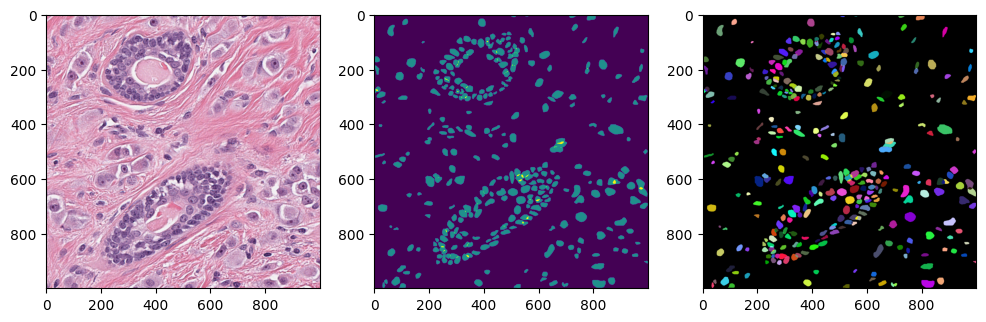

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(12, 12))

# Assuming 'orig', 'binary_mask', and 'color_mask' contain your image data

# Normalize each image before visualization
axes[0].imshow(orig / 255.0)  # Assuming orig is in the range [0, 255]
axes[1].imshow(binary_mask / 255.0)  # Assuming binary_mask is in the range [0, 255]
axes[2].imshow(color_mask / 255.0)  # Assuming color_mask is in the range [0, 255]

plt.show()

#Getting Data Ready for Batching

In [47]:
X = [] # this will store all original images
y = [] # this will store all original binary masked images...I discard color masks
for i in orig_binmask_colormask:
  X.append(i['original_image'])
  y.append(i['binary_mask'])


In [56]:
#Data Augmentation 
from augmentations import apply_aug
X_augmented = []
y_augmented = []

for i in orig_binmask_colormask:
    orig = i['original_image']
    mask = i['binary_mask']

    trans_orig_1, trans_mask_1, trans_orig_2, trans_mask_2  = apply_aug(orig, mask)
    X_augmented.append(trans_orig_1), X_augmented.append(trans_orig_2)
    y_augmented.append(trans_mask_1), y_augmented.append(trans_mask_2)



INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


Text(0.5, 1.0, 'Mask')

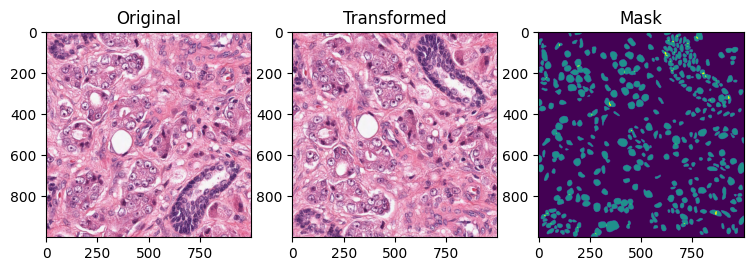

In [57]:
fig, ax = plt.subplots(1, 3, figsize=(9, 9))

ax[0].imshow(X[0])
ax[0].set_title("Original")
ax[1].imshow(X_augmented[1])
ax[1].set_title("Transformed")
ax[2].imshow(y_augmented[1])
ax[2].set_title("Mask")


#Compile All Images And Masks

In [58]:
all_Images = X + X_augmented      #MoNuSeg, MoNuSeg Augmented, CryoNuSeg, CryoNuSeg Augmented 
all_Masks = y + y_augmented       #MoNuSeg, MoNuSeg Augmented, CryoNuSeg, CryoNuSeg Augmented 
print(len(all_Images)), print(len(all_Masks))

90
90


(None, None)

In [59]:
import numpy
X_tensor = torch.Tensor(numpy.array(all_Images))
print(X_tensor.shape)
X_tensor = torch.permute(X_tensor, (0, 3, 1, 2)) #Turn tensor into a format understandable by pytorch
print(X_tensor.shape)
y_tensor = torch.Tensor(numpy.array(all_Masks))
print(y_tensor.shape)

torch.Size([90, 1000, 1000, 3])
torch.Size([90, 3, 1000, 1000])
torch.Size([90, 1000, 1000])


#Setup Configs + Batching



In [60]:
EPOCHS = 5

BATCH_SIZE = 3
learning_rate = 0.05
test_ratio = 0.3

ENCODER = 'timm-efficientnet-b7'
WEIGHTS = 'imagenet'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=test_ratio, random_state=42)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(63, 27, 63, 27)

In [ ]:
print(X_train.shape)
print(y_train.shape)

torch.Size([63, 3, 1000, 1000])
torch.Size([63, 1000, 1000])


In [55]:
train_set = TensorDataset(X_train, y_train)
test_set = TensorDataset(X_test, y_test)

In [56]:
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

In [57]:
print(len(train_loader))
print(len(test_loader))


21
9


#Segmentation Model ... Temporary until the model file is built

In [99]:
from UNET_model import UNet

n_channels = 3
out_channels = 1 # output shape is H W C and a mask should have 1 channel
bilinear = True

model_0 = UNet(n_channels, out_channels, bilinear)
model_0

# class SegmentationModel(nn.Module):
#   def __init__(self, num_classes=1):
#     super().__init__()
#     #self.pad = nn.ZeroPad2d((6, 6, 6, 6))
#     self.architecture = smp.Unet(
#       encoder_name=ENCODER,
#       encoder_weights = WEIGHTS,
#       in_channels = 3,
#       classes=num_classes
#     )

#   def forward(self, x):
#     orig_h, orig_w = x.size()[-2:]
#     # Apply padding to make the dimensions divisible by 32
#     pad_h = ((orig_h // 32) + 1) * 32 - orig_h
#     pad_w = ((orig_w // 32) + 1) * 32 - orig_w
#     # Apply padding
#     x = nn.ZeroPad2d((0, pad_w, 0, pad_h))(x)
#     # Pass the padded input through the UNet architecture
#     output = self.architecture(x)
#     return output

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [61]:
summary(model_0)

Layer (type:depth-idx)                        Param #
UNet                                          --
├─DoubleConv: 1-1                             --
│    └─Sequential: 2-1                        --
│    │    └─Conv2d: 3-1                       1,792
│    │    └─BatchNorm2d: 3-2                  128
│    │    └─ReLU: 3-3                         --
│    │    └─Conv2d: 3-4                       36,928
│    │    └─BatchNorm2d: 3-5                  128
│    │    └─ReLU: 3-6                         --
├─Down: 1-2                                   --
│    └─Sequential: 2-2                        --
│    │    └─MaxPool2d: 3-7                    --
│    │    └─DoubleConv: 3-8                   221,952
├─Down: 1-3                                   --
│    └─Sequential: 2-3                        --
│    │    └─MaxPool2d: 3-9                    --
│    │    └─DoubleConv: 3-10                  886,272
├─Down: 1-4                                   --
│    └─Sequential: 2-4                       

In [62]:
num_params = sum(p.numel() for p in model_0.parameters())
num_params

31390721

In [ ]:
#practice inference on untrained model
from visualize import visualize_segmentation
for image, annote in test_loader:
  logits = model_0(image)
  visualize_segmentation(image, annote, logits)
# batch_size = 7
# images = torch.randn(batch_size, 3, 512, 512).to(device)  # Random images
# targets = torch.randint(0, 2, (batch_size, 512, 512)).to(device)  # Random ground truth masks
# outputs = model(images)  # Model predictions

# # Visualize the first 3 images, masks, and predictions
# visualize_segmentation(images.detach().cpu(), targets.detach().cpu(), outputs.detach().cpu(), num_images=3)

#Metrics

In [100]:
DICE_loss = DiceLoss(mode='binary')
BCE_loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=learning_rate)

In [101]:
def accuracy_metric(pred, gt):
  with torch.no_grad():
    pred = torch.argmax(F.softmax(pred, dim=1), dim=1)
    correct = torch.eq(pred, gt).int()
    accuracy = (float(correct.sum()))/float(correct.numel())
  return accuracy


#Training Loop

In [102]:
def train(model, optimizer):
    model.train()
    total_train_loss = 0
    train_losses = []
    #eval_losses = []
    print(f"Number of Images Trained on: {num_of_images_in_pipeline} | # Epochs: {EPOCHS} | LR: {learning_rate} | Number of Params: {num_params}")

    for epoch in tqdm(range(EPOCHS)):
        epoch_train_loss = 0
        for batch_idx, (image, annote) in enumerate(train_loader):
            print(f"Epoch #{epoch}_______Batch #{batch_idx}...")
            logits = model(image)
            annote = annote.unsqueeze(1)

            dice_loss = DICE_loss(logits, annote)
            bce_loss = BCE_loss(logits, annote)
            loss = dice_loss + bce_loss

            print(f"Dice Loss: {dice_loss.item()}  BCE Loss: {bce_loss.item()}")

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        epoch_train_loss /= len(train_loader)
        total_train_loss += epoch_train_loss
        print(f"Epoch {epoch} Train Loss: {epoch_train_loss}")

    total_train_loss /= EPOCHS
    train_losses.append(total_train_loss)
    print(f"Total Training Loss: {total_train_loss}")
    return total_train_loss

In [104]:
def test(model):
    model.eval()
    total_dice_loss = 0
    total_bce_loss = 0

    with torch.no_grad():
        for image, annote in test_loader:
            test_logits = model(image)
            annote = annote.unsqueeze(1)  # Ensure the annotation shape matches the logits shape if needed

            dice_loss = DICE_loss(test_logits, annote)
            bce_loss = BCE_loss(test_logits, annote)


            total_dice_loss += dice_loss.item()
            total_bce_loss += bce_loss.item()

    avg_dice_loss = total_dice_loss / len(test_loader)
    avg_bce_loss = total_bce_loss / len(test_loader)

    return print(f'DICEL: {avg_dice_loss}, BCEL: {avg_bce_loss}')

In [105]:
train(model_0, optimizer)

Number of Images Trained on: 30 | # Epochs: 5 | LR: 0.05 | Number of Params: 31390721


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0_______Batch #0...


  0%|          | 0/5 [00:11<?, ?it/s]


KeyboardInterrupt: 

torch.Size([1000, 1000, 3])
Output shape: torch.Size([1, 1, 1000, 1000])


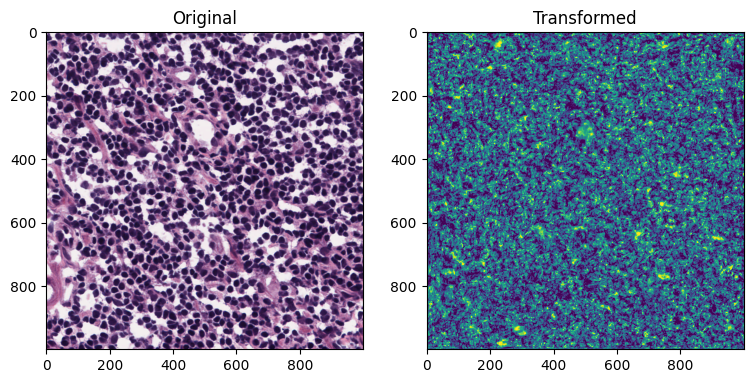

In [97]:
import torch
import matplotlib.pyplot as plt
import numpy as np

image = X_test[3]
image = image / 255.0

image_for_visualization = torch.permute(image, (1, 2, 0))
print(image_for_visualization.shape)

image_for_visualization = image_for_visualization.numpy()
image_for_visualization = np.clip(image_for_visualization, 0, 1)

image = image.unsqueeze(0)  # Add batch dimension bc model expects it

output = model_0(image)

print("Output shape:", output.shape)

output_image = output.squeeze(0).permute(1, 2, 0).detach().numpy()

# Ensure the data is in the valid range for imshow
output_image = np.clip(output_image, 0, 1)

fig, ax = plt.subplots(1, 2, figsize=(9, 9))
ax[0].imshow(image_for_visualization)
ax[0].set_title("Original")

ax[1].imshow(output_image)
ax[1].set_title("Transformed")

plt.show()


In [ ]:
#Visualize Prediction Images
image = X[3]
#print(image.shape), print(image.dtype)
#plt.imshow(image)
image = image.numpy()
image = np.clip(image, 0, 1)
image = image.unsqueeze(0)  # Add batch dimension



# image = torch.Tensor(image)
output = model_0(image)
output_image = output.squeeze().permute(1, 2, 0).detach().numpy()
output_image = np.clip(output_image, 0, 1)


fig, ax = plt.subplots(1, 2, figsize=(9, 9))
ax[0].imshow(image)
ax[1].imshow(output_image)



In [ ]:
from pathlib import Path

MODEL_PATH = Path("/content/Cell_Seg_Count-CMU-main")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "fully_trained_seg_unet1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
#MODEL_SAVE_PATH

print(f'Saving model to {MODEL_SAVE_PATH}')
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

Saving model to /content/Cell_Seg_Count-CMU/fully_trained_seg_unet1.pth


In [36]:
trained_model_PATH = 'fully_trained_seg_unet1.pth'
UNET_model = UNet(n_channels, out_channels, bilinear)
UNET_model.load_state_dict(torch.load(trained_model_PATH))
UNET_model.eval()
with torch.inference_mode():
  test(model_0)

DICEL: 0.7144297162691752, BCEL: 1.3769508335325453


In [ ]:
for image, annote in test_loader:
  output = UNET_model(image)
  accuracy = accuracy_metric(output, annote)
  print(accuracy)